<a href="https://colab.research.google.com/github/escapingLife/mashinePrograming/blob/master/7%EC%A3%BC%EC%B0%A8/CIFAR_10_classification_in_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

# ========================================
# CIFAR-10 데이터를 저장할 경로
# ========================================
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/cifar10_data'

In [3]:
# 데이터 디렉토리 생성
os.makedirs(DATA_DIR, exist_ok=True)

# --- CIFAR-10 로드 (자동으로 캐싱) ---
# Keras는 기본적으로 ~/.keras/datasets에 저장하지만,
# 명시적으로 경로를 지정하려면 아래와 같이 처리
cifar10_path = os.path.join(DATA_DIR,'cifar-10-batches-py')

if os.path.exists(cifar10_path):
    print(f"✓ 기존 데이터 발견: {cifar10_path}")
    print("저장된 데이터를 로드합니다...")
else:
    print(f"데이터가 없습니다. {DATA_DIR}에 다운로드합니다...")

# 데이터 로드 (없으면 자동 다운로드 후 캐싱)
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"✓ 데이터 로드 완료")
print(f"  - 학습 데이터: {x_train.shape}")
print(f"  - 테스트 데이터: {x_test.shape}\n")

데이터가 없습니다. /content/drive/MyDrive/Colab Notebooks/cifar10_data에 다운로드합니다...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
✓ 데이터 로드 완료
  - 학습 데이터: (50000, 32, 32, 3)
  - 테스트 데이터: (10000, 32, 32, 3)



In [4]:
# 클래스 이름 정의
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

# 사용할 클래스 선택
selected_classes = ['cat','dog','horse']
selected_idx = [class_names.index(c)for c in selected_classes]

In [5]:
# --- 해당 클래스만 필터링 ---
train_mask = np.isin(y_train, selected_idx).flatten()
test_mask = np.isin(y_test, selected_idx).flatten()

In [6]:
x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

print(f"선택된 클래스: {selected_classes}")
print(f"  - 학습 샘플 수: {len(x_train)}")
print(f"  - 테스트 샘플 수: {len(x_test)}\n")

선택된 클래스: ['cat', 'dog', 'horse']
  - 학습 샘플 수: 15000
  - 테스트 샘플 수: 3000



In [7]:
# 라벨을 0~2로 다시 매핑
label_map = {v: i for i, v in enumerate(selected_idx)}
y_train = np.array([label_map[int(y)]for y in y_train])
y_test = np.array([label_map[int(y)]for y in y_test])

/tmp/ipython-input-2451507799.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_train = np.array([label_map[int(y)]for y in y_train])
/tmp/ipython-input-2451507799.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_test = np.array([label_map[int(y)]for y in y_test])


In [8]:
# 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -----------------------------
# 2. 데이터 증강 (Data Augmentation)
# -----------------------------
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
datagen.fit(x_train)

In [25]:
# -----------------------------
# 3. CNN 모델 정의
# -----------------------------
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.35),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3개 클래스
])


In [26]:
# ========================================
# 4. 모델 컴파일
# ========================================
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # y가 one-hot이 아니므로 sparse 사용
    metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------
# 5. EarlyStopping 설정
# -----------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [29]:
# ========================================
# 6. 모델 학습
# ========================================
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20,
    batch_size=64,
    verbose=2
)

Epoch 1/20
235/235 - 15s - 64ms/step - accuracy: 0.5448 - loss: 1.0807 - val_accuracy: 0.3330 - val_loss: 1.4041
Epoch 2/20
235/235 - 2s - 7ms/step - accuracy: 0.6441 - loss: 0.7738 - val_accuracy: 0.4693 - val_loss: 1.1158
Epoch 3/20
235/235 - 2s - 7ms/step - accuracy: 0.6987 - loss: 0.6714 - val_accuracy: 0.6933 - val_loss: 0.6938
Epoch 4/20
235/235 - 2s - 8ms/step - accuracy: 0.7245 - loss: 0.6267 - val_accuracy: 0.7203 - val_loss: 0.6425
Epoch 5/20
235/235 - 2s - 8ms/step - accuracy: 0.7505 - loss: 0.5818 - val_accuracy: 0.7297 - val_loss: 0.6142
Epoch 6/20
235/235 - 2s - 8ms/step - accuracy: 0.7600 - loss: 0.5574 - val_accuracy: 0.7363 - val_loss: 0.6116
Epoch 7/20
235/235 - 2s - 7ms/step - accuracy: 0.7788 - loss: 0.5276 - val_accuracy: 0.7533 - val_loss: 0.5735
Epoch 8/20
235/235 - 2s - 7ms/step - accuracy: 0.7896 - loss: 0.5045 - val_accuracy: 0.7740 - val_loss: 0.5319
Epoch 9/20
235/235 - 2s - 7ms/step - accuracy: 0.8047 - loss: 0.4770 - val_accuracy: 0.7883 - val_loss: 0.4947

In [30]:
# ========================================
# 7. 모델 평가
# ========================================
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\n CNN Test Accuracy: {test_acc:.4f}")

94/94 - 1s - 15ms/step - accuracy: 0.8193 - loss: 0.4760

 CNN Test Accuracy: 0.8193


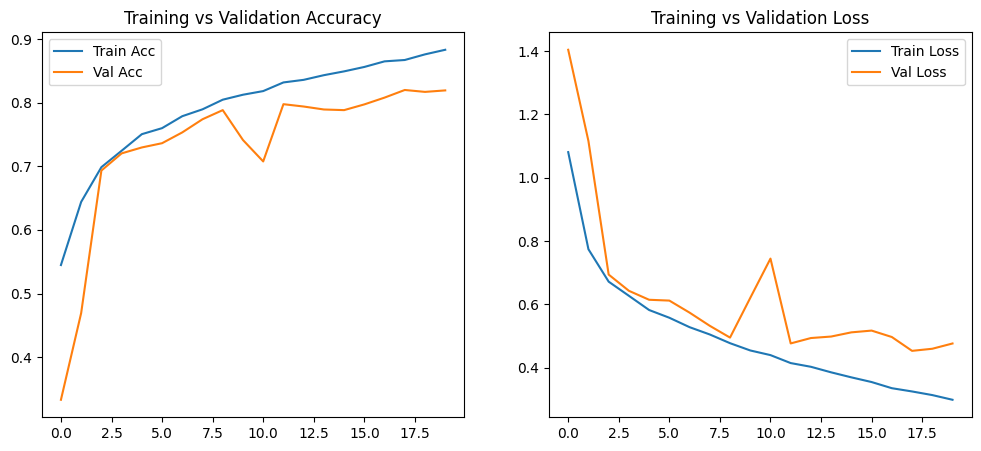

In [31]:
# ========================================
# 8. 학습 결과 시각화
# ========================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()